In [156]:
%reload_ext autoreload
%autoreload

In [157]:
import pandas as pd
import geopandas as gpd
import shapely
import nomad.io.base as loader
import numpy as np
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import nomad.stop_detection.utils as utils
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.visit_attribution as visits
import nomad.filters as filters
import nomad.city_gen as cg

from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1

In [ ]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

def classify_building_size_from_id(building_id):
    building = city.buildings.get(building_id)
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

def classify_building_type_from_id(building_id):
    building = city.buildings.get(building_id)
    return building.building_type

def classify_dwell(duration):
    if duration <= 5:
        return 'low'
    elif 6 <= duration <= 120:
        return 'mid'
    else:
        return 'high'

In [187]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')
# building type
poi_table = poi_table.rename({'type':'building_type'}, axis=1)
# building size
poi_table['building_size'] = poi_table['building_id'].apply(classify_building_size_from_id)

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1)
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_size']], on='building_id')
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_type']], on='building_id')
diaries_df['dwell_length'] = diaries_df['duration'].apply(classify_dwell)

sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,)

In [196]:
diaries_df

,uid,timestamp,longitude,latitude,x,y,date,datetime,duration,building_id,tz_offset,building_size,building_type,dwell_length
0,gracious_babbage,1704099840,-38.318685,36.669407,-4265616.5,4393126.0,2024-01-01,2024-01-01 08:04:00,237,w-x6-y9,-3600,medium,work,high
1,gracious_babbage,1704114180,-38.319157,36.669569,-4265669.0,4393148.5,2024-01-01,2024-01-01 12:03:00,13,r-x3-y11,-3600,medium,retail,mid
2,gracious_babbage,1704115440,-38.317338,36.668488,-4265466.5,4392998.5,2024-01-01,2024-01-01 12:24:00,52,r-x15-y0,-3600,small,retail,mid
3,gracious_babbage,1704118800,-38.318483,36.668596,-4265594.0,4393013.5,2024-01-01,2024-01-01 13:20:00,26,r-x6-y3,-3600,medium,retail,mid
4,gracious_babbage,1704120540,-38.317876,36.668542,-4265526.5,4393006.0,2024-01-01,2024-01-01 13:49:00,12,r-x12-y3,-3600,big,retail,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21909,mystifying_wozniak,1705243080,-38.317338,36.668596,-4265466.5,4393013.5,2024-01-14,2024-01-14 13:38:00,23,r-x15-y3,-3600,small,retail,mid
21910,mystifying_wozniak,1705244520,-38.317338,36.668866,-4265466.5,4393051.0,2024-01-14,2024-01-14 14:02:00,239,w-x15-y3,-3600,big,work,high
21911,mystifying_wozniak,1705259220,-38.317472,36.669677,-4265481.5,4393163.5,2024-01-14,2024-01-14 18:07:00,99,h-x13-y12,-3600,small,home,mid
21912,mystifying_wozniak,1705265400,-38.316799,36.669839,-4265406.5,4393186.0,2024-01-14,2024-01-14 19:50:00,11,r-x18-y13,-3600,medium,retail,mid


## Analyze completeness

In [189]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)
print(completeness_df.columns)

Index(['uid', 'q_stat'], dtype='object')


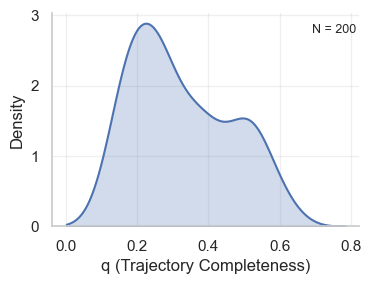

In [190]:
plt.figure(figsize=(4,3))
ax = sns.kdeplot(
    data=completeness_df,
    x="q_stat",
    fill=True,
    linewidth=1.5,
    clip=(0, 1)
)

# cosmetics
ax.set_xlabel("q (Trajectory Completeness)")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.3)
sns.despine(top=True, right=True)

# annotation (top-right corner in axes coords)
ax.text(
    0.99, 0.95,
    f"N = {len(completeness_df)}",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=9
)

plt.tight_layout()
plt.savefig("q_stat_density.svg", format="svg", bbox_inches="tight")
plt.savefig("q_stat_density.png", format="svg", bbox_inches="tight")
plt.show()

## Execution for all users

In [191]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id']) # < function(grouped_data)

In [7]:
%%time
DUR_MIN=5
DT_MAX=90
DELTA_ROAM=30
# to summarize stops after groupby passing through individual locations
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id']) # < function(grouped_data)

# If we want to use 'majority' to attribute visits, then we need stop labels on each ping
labels_hdbscan = HDBSCAN.hdbscan_labels(traj=sparse1,
                                            time_thresh=100,
                                            min_pts=2,
                                            min_cluster_size=3,
                                            traj_cols=traj_cols)
labels_hdbscan.name = 'cluster'
# join with the original data
sparse_with_cluster = sparse1.join(labels_hdbscan)

# has same index as data
pred_hdbscan = visits.point_in_polygon(data=sparse_with_cluster,
                                        poi_table=poi_table,
                                        method='majority',
                                        data_crs='EPSG:3857',
                                        max_distance=10,
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')
# join the building id
pred = sparse_with_cluster.join(pred_hdbscan)

stop_table_hdbscan = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
stop_table_hdbscan.head()

CPU times: total: 500 ms
Wall time: 498 ms


,cluster,x,y,start_timestamp,duration,building_id
0,1,-4.265619e+06,4.393128e+06,1704121740,137,w-x6-y9
1,2,-4.265575e+06,4.393197e+06,1704154440,63,h-x8-y13
2,3,-4.265570e+06,4.393182e+06,1704172860,11,h-x8-y13
3,4,-4.265439e+06,4.393106e+06,1704271980,32,w-x18-y8
4,5,-4.265617e+06,4.393127e+06,1704363840,233,w-x6-y9


In [197]:
poi_table

,building_id,building_type,geometry,building_size
0,p-x13-y11,park,"POLYGON ((-4265504 4393111, -4265504 4393171, ...",big
1,h-x8-y8,home,"POLYGON ((-4265579 4393081, -4265579 4393111, ...",medium
2,h-x9-y8,home,"POLYGON ((-4265549 4393081, -4265549 4393096, ...",medium
3,h-x10-y8,home,"POLYGON ((-4265534 4393081, -4265534 4393096, ...",small
4,h-x11-y8,home,"POLYGON ((-4265519 4393081, -4265519 4393096, ...",small
...,...,...,...,...
101,r-x3-y7,retail,"POLYGON ((-4265654 4393081, -4265654 4393096, ...",medium
102,r-x0-y5,retail,"POLYGON ((-4265669 4393036, -4265669 4393081, ...",medium
103,r-x3-y6,retail,"POLYGON ((-4265654 4393066, -4265654 4393081, ...",small
104,r-x3-y5,retail,"POLYGON ((-4265654 4393051, -4265654 4393066, ...",small


In [ ]:
stop_detection_algos = ['oracle', 'lachesis', 'ta-dbscan', 'hdbscan']

all_metrics_df = pd.DataFrame()
metrics_size_df = pd.DataFrame()
metrics_btype_df = pd.DataFrame()
metrics_dwell_df = pd.DataFrame()

TIME_THRESH=240
DIST_THRESH=25
MIN_PTS=2

DUR_MIN=5
DT_MAX=240
DELTA_ROAM=35

for user in tqdm(diaries_df.uid.unique()[:1], desc='Processing users'):
    for algo in stop_detection_algos:
        sparse = sparse_df[sparse_df['uid'] == user].copy()
        truth = diaries_df.loc[diaries_df['uid'] == user].copy()
        
        if algo == 'oracle':
            # oracle says correct poi for each ping
            location = visits.oracle_map(
                sparse,
                truth,
                timestamp='timestamp',
                location_id='building_id')
            # find cluster labels with naive grid-based continuity
            labels = GRID_BASED.grid_based_labels(
                data=sparse.join(location),
                time_thresh=TIME_THRESH,
                min_pts=0, #we allow stops of duration 0, patched later
                location_id='building_id',
                traj_cols=traj_cols)
        
        elif algo == 'lachesis':
            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dt_max=DT_MAX,
                dur_min=DUR_MIN,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols)
            
            labels.name = 'cluster'           
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'ta-dbscan':
            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'hdbscan':
            labels = HDBSCAN.hdbscan_labels(
                traj=sparse,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=1,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
        else:
            print(f"Algorithm {algo} not in the list!")

        # ----------- COMPUTE STOPS FROM LABELS -----------------------
        if algo != 'oracle': 
            pred = visits.point_in_polygon(data=sparse_with_cluster,
                                            poi_table=poi_table,
                                            method='majority',
                                            data_crs='EPSG:3857',
                                            max_distance=15,
                                            cluster_label='cluster',
                                            location_id='building_id',
                                            x='x',
                                            y='y')
        
            pred = sparse_with_cluster.join(pred)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
        # ------------------------------ POST PROCESSING SHOULD BE EMBEDDED IN ALGORITHMS -------------------------------------
            try:
                utils.invalid_stops(stops)
            except:
                print(f"Algorithm {algo} has overlapping stops for user {user}. Postprocessing.")
                labels = GRID_BASED.grid_based_labels(
                                data=pred.drop('cluster', axis=1),
                                time_thresh=TIME_THRESH,
                                min_pts=0, #we allow stops of duration 0, patched later
                                location_id='building_id',
                                traj_cols=traj_cols)
                
                pred['cluster'] = labels
                stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
         # -------------------------------------------------------------------            
        else: #location exists by oracle, we join everything
            pred = sparse.join(location).join(labels)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            # we add a 5min duration to oracle stops with just one ping
            stops = utils.pad_short_stops(stops, pad=5, dur_min=0, start_timestamp = 'start_timestamp')

        # ------------------------------ COMPUTE METRICS OF INTEREST -------------------------------------
        # general metrics
        overlaps = overlapping_visits(left=stops,
                                      right=truth,
                                      location_id='building_id',
                                      match_location=False)

        errors = compute_visitation_errors(overlaps=overlaps,
                                           true_visits=truth,
                                           location_id='building_id')

        prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_visits=stops,
                                           true_visits=truth,
                                           location_id='building_id')
        
        all_metrics = {**errors, **prf1, 'user': user, 'algorithm': algo}
        
        
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

        # WARNING THIS IS WRONG...
        # TO DO: The true way to filter stops, is not with attributes based on PREDICTED location
        # instead, we need clip the stop table to the intervals given by the truth table. >>> PACO
        
        # size metrics
        stops_with_attr = stops.merge(poi_table[['building_id', 'building_size', 'building_type']], on='building_id')

        for build_size in ['small', 'medium', 'big']:    
            if (truth.building_size==build_size).sum() == 0:
                continue
                
            overlaps = overlapping_visits(
                            left=stops_with_attr.loc[stops_with_attr.building_size==build_size],
                            right=truth.loc[truth.building_size==build_size],
                            location_id='building_id',
                            match_location=False)
            
            errors = compute_visitation_errors(overlaps=overlaps,
                                               true_visits=truth.loc[truth.building_size==build_size],
                                               location_id='building_id')
            
            prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                               pred_visits=stops_with_attr.loc[stops_with_attr.building_size==build_size],
                                               true_visits=truth.loc[truth.building_size==build_size],
                                               location_id='building_id')
            
            
            metrics_size = {**errors, **prf1, 'user': user, 'algorithm': algo, 'building_size':build_size}
            metrics_size_df = pd.concat([metrics_size_df, pd.DataFrame([metrics_size])], ignore_index=True)

        # btype metrics
        for building_type in ['home', 'retail', 'work', 'park']:    
            if (truth.building_type==building_type).sum() == 0:
                continue
                
            overlaps = overlapping_visits(
                            left=stops_with_attr.loc[stops_with_attr.building_type==building_type],
                            right=truth.loc[truth.building_type==building_type],
                            location_id='building_id',
                            match_location=False)
            
            errors = compute_visitation_errors(overlaps=overlaps,
                                               true_visits=truth.loc[truth.building_type==building_type],
                                               location_id='building_id')
            
            prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                               pred_visits=stops_with_attr.loc[stops_with_attr.building_type==building_type],
                                               true_visits=truth.loc[truth.building_type==building_type],
                                               location_id='building_id')
            
            
            metrics_btype = {**errors, **prf1, 'user': user, 'algorithm': algo, 'building_type':building_type}
            metrics_btype_df = pd.concat([metrics_btype_df, pd.DataFrame([metrics_btype])], ignore_index=True)

        # btype metrics
        for dwell_length in ['low', 'mid', 'high']:    
            if (truth.dwell_length==dwell_length).sum() == 0:
                continue
                
            overlaps = overlapping_visits(
                            left=stops_with_attr,
                            right=truth.loc[truth.dwell_length==dwell_length],
                            location_id='building_id',
                            match_location=False)
            
            errors = compute_visitation_errors(overlaps=overlaps,
                                               true_visits=truth.loc[truth.dwell_length==dwell_length],
                                               location_id='building_id')
            
            prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                               pred_visits=stops_with_attr,
                                               true_visits=truth.loc[truth.dwell_length==dwell_length],
                                               location_id='building_id')
            
            
            metrics_dwell = {**errors, **prf1, 'user': user, 'algorithm': algo, 'dwell_length':dwell_length}
            metrics_dwell_df = pd.concat([metrics_dwell_df, pd.DataFrame([metrics_dwell])], ignore_index=True)

In [262]:
stops

,cluster,x,y,start_timestamp,duration,building_id
0,0,-4.265619e+06,4.393128e+06,1704121740,137,w-x6-y9
1,1,-4.265575e+06,4.393197e+06,1704154440,63,h-x8-y13
2,2,-4.265570e+06,4.393182e+06,1704172860,11,h-x8-y13
3,3,-4.265557e+06,4.393184e+06,1704247140,4,h-x9-y13
4,4,-4.265439e+06,4.393106e+06,1704271980,32,w-x18-y8
5,5,-4.265617e+06,4.393127e+06,1704363840,233,w-x6-y9
6,6,-4.265443e+06,4.393183e+06,1704557100,43,w-x18-y13
7,7,-4.265507e+06,4.393194e+06,1704662880,24,h-x12-y13
8,8,-4.265613e+06,4.393125e+06,1704736500,27,w-x6-y9
9,9,-4.265541e+06,4.393095e+06,1704773340,8,h-x10-y8


In [260]:
stops_with_attr.loc[stops_with_attr.building_size=='medium']

,cluster,x,y,start_timestamp,duration,building_id,building_size,building_type
0,0,-4.265619e+06,4.393128e+06,1704121740,137,w-x6-y9,medium,work
4,4,-4.265439e+06,4.393106e+06,1704271980,32,w-x18-y8,medium,work
5,5,-4.265617e+06,4.393127e+06,1704363840,233,w-x6-y9,medium,work
8,8,-4.265613e+06,4.393125e+06,1704736500,27,w-x6-y9,medium,work
10,10,-4.265612e+06,4.393122e+06,1704800160,56,w-x6-y9,medium,work
11,11,-4.265550e+06,4.393093e+06,1704901980,366,w-x6-y9,medium,work
14,14,-4.265589e+06,4.393121e+06,1705035480,134,h-x8-y10,medium,home
15,15,-4.265590e+06,4.393096e+06,1705091820,656,h-x8-y8,medium,home
16,16,-4.265610e+06,4.393126e+06,1705233480,326,w-x6-y9,medium,work


In [265]:
truth.loc[truth.building_size=='medium']

,uid,timestamp,longitude,latitude,x,y,date,datetime,duration,building_id,tz_offset,building_size,building_type,dwell_length
0,gracious_babbage,1704099840,-38.318685,36.669407,-4265616.5,4393126.0,2024-01-01,2024-01-01 08:04:00,237,w-x6-y9,-3600,medium,work,high
1,gracious_babbage,1704114180,-38.319157,36.669569,-4265669.0,4393148.5,2024-01-01,2024-01-01 12:03:00,13,r-x3-y11,-3600,medium,retail,mid
3,gracious_babbage,1704118800,-38.318483,36.668596,-4265594.0,4393013.5,2024-01-01,2024-01-01 13:20:00,26,r-x6-y3,-3600,medium,retail,mid
5,gracious_babbage,1704121560,-38.318685,36.669407,-4265616.5,4393126.0,2024-01-01,2024-01-01 14:06:00,235,w-x6-y9,-3600,medium,work,high
7,gracious_babbage,1704186420,-38.318483,36.668596,-4265594.0,4393013.5,2024-01-02,2024-01-02 08:07:00,24,r-x6-y3,-3600,medium,retail,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,gracious_babbage,1705223100,-38.318685,36.669407,-4265616.5,4393126.0,2024-01-14,2024-01-14 08:05:00,86,w-x6-y9,-3600,medium,work,mid
114,gracious_babbage,1705228560,-38.317742,36.668812,-4265511.5,4393043.5,2024-01-14,2024-01-14 09:36:00,145,w-x12-y3,-3600,medium,work,high
115,gracious_babbage,1705237620,-38.319157,36.669569,-4265669.0,4393148.5,2024-01-14,2024-01-14 12:07:00,84,r-x3-y11,-3600,medium,retail,mid
117,gracious_babbage,1705244040,-38.319157,36.669569,-4265669.0,4393148.5,2024-01-14,2024-01-14 13:54:00,7,r-x3-y11,-3600,medium,retail,mid


In [268]:
overlapping_visits(
    left=stops_with_attr.loc[stops_with_attr.building_size=='medium'],
    right=truth.loc[truth.building_size=='medium'],
    location_id='building_id',
    match_location=False)

,start_timestamp_left,building_id_left,end_timestamp_left,start_timestamp_right,building_id_right,end_timestamp_right,duration
0,1704121740,w-x6-y9,1704129960,1704121560,w-x6-y9,1704135660,137
1,1704271980,w-x18-y8,1704273900,1704272700,w-x18-y8,1704286860,20
2,1704363840,w-x6-y9,1704377820,1704362700,w-x6-y9,1704373260,157
3,1704363840,w-x6-y9,1704377820,1704373620,r-x14-y18,1704376860,54
4,1704736500,w-x6-y9,1704738120,1704726420,w-x6-y9,1704740460,27
5,1704800160,w-x6-y9,1704803520,1704794640,w-x6-y9,1704805260,56
6,1704901980,w-x6-y9,1704923940,1704899220,w-x6-y9,1704913260,188
7,1704901980,w-x6-y9,1704923940,1704913560,r-x6-y3,1704915960,40
8,1704901980,w-x6-y9,1704923940,1704916380,r-x1-y18,1704916860,8
9,1705035480,h-x8-y10,1705043520,1705024980,h-x8-y10,1705050060,134


In [194]:
all_metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

,missed_fraction,merged_fraction,split_fraction,precision,recall,f1
algorithm,,,,,,
hdbscan,0.534078,0.191627,0.167616,0.973547,0.183279,0.304896
lachesis,0.603981,0.031495,0.109718,0.996593,0.235403,0.360955
oracle,0.560900,0.000000,0.017476,0.999629,0.254940,0.381253
ta-dbscan,0.622065,0.059532,0.067054,0.996734,0.262041,0.389710


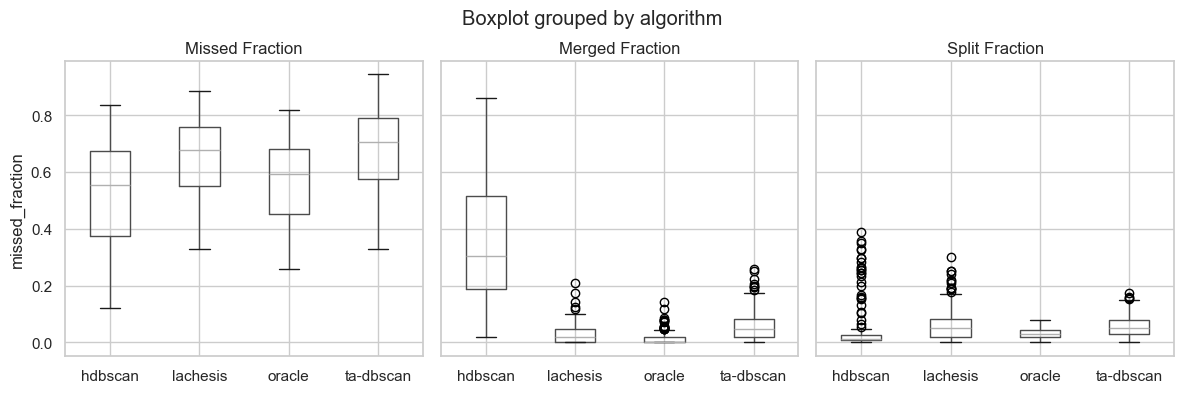

In [203]:
# first group: the three error‐fractions, share y‐axis [0,1]
frac_metrics = ["missed_fraction", "merged_fraction", "split_fraction"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for ax, metric in zip(axes, frac_metrics):
    all_metrics_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("")           # drop the “by …” label
    ax.set_ylabel(metric if ax is axes[0] else "")  # only leftmost gets ylabel
    ax.grid(True)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

In [204]:
# metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

bootstrapping=True
if bootstrapping:
    output = []
    agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
    agg_dict = {key:'median' for key in agg_keys}
    for _ in range(100):
        output += [all_metrics_df.sample(len(all_metrics_df), replace=True).groupby('algorithm', as_index=False).agg(agg_dict)]
    metrics_bootstrap_df = pd.concat(output)

In [205]:
metrics_bootstrap_df

,algorithm,missed_fraction,merged_fraction,split_fraction,precision,recall,f1
0,hdbscan,0.576577,0.293651,0.015873,0.975400,0.249366,0.397027
1,lachesis,0.681416,0.020619,0.050020,0.998028,0.186602,0.314475
2,oracle,0.596330,0.000000,0.028571,0.999254,0.202641,0.336964
3,ta-dbscan,0.669643,0.056604,0.054945,0.997137,0.213206,0.351356
0,hdbscan,0.572654,0.276488,0.010000,0.975992,0.234642,0.378141
...,...,...,...,...,...,...,...
3,ta-dbscan,0.716014,0.050000,0.050641,0.997271,0.188029,0.316410
0,hdbscan,0.538127,0.286927,0.017094,0.975393,0.244166,0.390713
1,lachesis,0.660550,0.020408,0.051020,0.997831,0.188321,0.316467
2,oracle,0.581685,0.000000,0.028037,0.999441,0.220247,0.360981


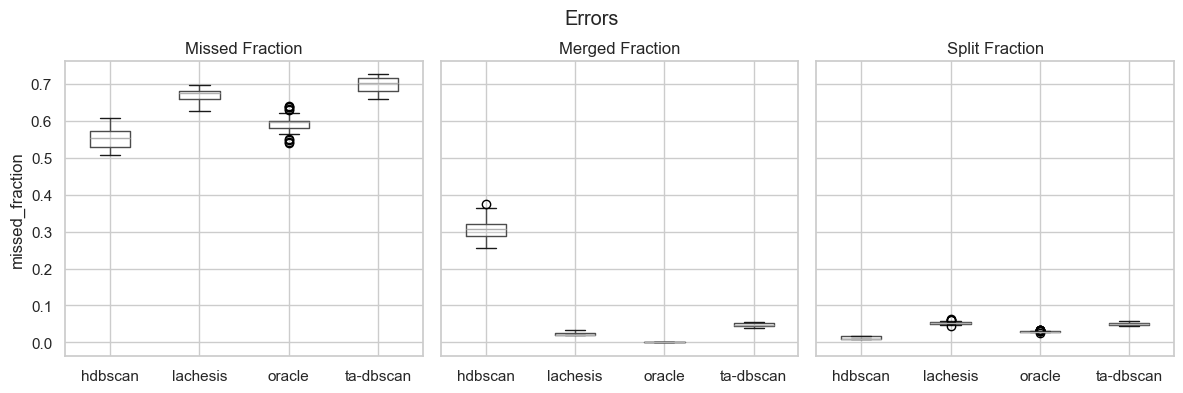

In [212]:
# first group: the three error‐fractions, share y‐axis [0,1]
frac_metrics = ["missed_fraction", "merged_fraction", "split_fraction"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for ax, metric in zip(axes, frac_metrics):
    metrics_bootstrap_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("")           # drop the “by …” label
    ax.set_ylabel(metric if ax is axes[0] else "")  # only leftmost gets ylabel
    ax.grid(True)
fig.suptitle("Errors")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

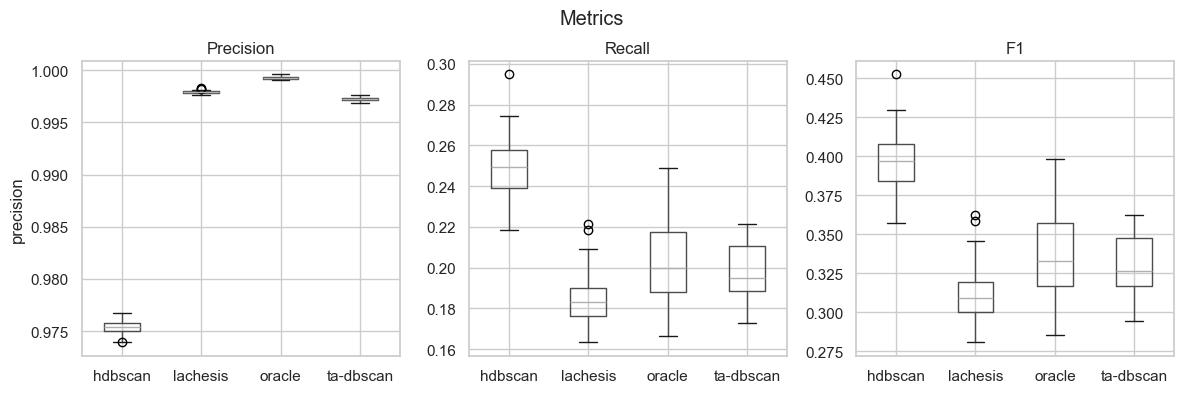

In [244]:
prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, metric in zip(axes, prf_metrics):
    metrics_bootstrap_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.upper() if metric=="f1" else metric.title())
    ax.set_xlabel("")
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.grid(True)
fig.suptitle("Metrics")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

## Exploration of building size

In [ ]:
prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, metric in zip(axes, prf_metrics):
    metrics_bootstrap_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.upper() if metric=="f1" else metric.title())
    ax.set_xlabel("")
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.grid(True)
fig.suptitle("Metrics")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
dfs_plotting = [metrics_size_df, metrics_btype_df, metrics_dwell_df]

In [250]:
metrics_btype_df[(metrics_btype_df['user'] == 'mystifying_wozniak') & (metrics_btype_df['building_type'] == 'home')]

,missed_fraction,merged_fraction,split_fraction,precision,recall,f1,user,algorithm,building_type
3184,0.304348,0.000000,0.130435,1.000000,0.348110,0.516442,mystifying_wozniak,oracle,home
3188,0.304348,0.000000,0.260870,1.000000,0.314347,0.478332,mystifying_wozniak,lachesis,home
3192,0.304348,0.000000,0.173913,1.000000,0.342826,0.510604,mystifying_wozniak,ta-dbscan,home
3196,0.391304,0.086957,0.000000,0.757138,0.375246,0.501796,mystifying_wozniak,hdbscan,home


In [ ]:
metrics_btype_df

In [254]:
all_metrics_df.groupby(['algorithm'])[['precision','recall','f1']].mean()

,precision,recall,f1
algorithm,,,
hdbscan,0.975566,0.304788,0.433540
lachesis,0.997325,0.222344,0.344907
oracle,0.998527,0.243798,0.370921
ta-dbscan,0.996748,0.233370,0.357096


In [253]:
metrics_btype_df.groupby(['algorithm'])[['precision','recall','f1']].median()

,precision,recall,f1
algorithm,,,
hdbscan,0.615385,0.100661,0.167069
lachesis,0.994452,0.119506,0.210162
oracle,1.000000,0.145766,0.254443
ta-dbscan,0.992218,0.116363,0.205349


In [227]:
output = []
agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
agg_dict = {key:'median' for key in agg_keys}

for _ in range(100):
    output += [metrics_size_df.sample(len(metrics_size_df), replace=True).groupby(['algorithm', 'building_size'], as_index=False).agg(agg_dict)]

size_bootstrap_df = pd.concat(output)

output = []
for _ in range(100):
    output += [metrics_btype_df.sample(len(metrics_btype_df), replace=True).groupby(['algorithm', 'building_type'], as_index=False).agg(agg_dict)]

btype_bootstrap_df = pd.concat(output)

output = []
for _ in range(100):
    output += [metrics_dwell_df.sample(len(metrics_dwell_df), replace=True).groupby(['algorithm', 'dwell_length'], as_index=False).agg(agg_dict)]

dwell_bootstrap_df = pd.concat(output)


In [228]:
size_bootstrap_df


,algorithm,building_size,missed_fraction,merged_fraction,split_fraction,precision,recall,f1
0,hdbscan,big,0.837838,0.000000,0.000000,0.552430,0.113655,0.185968
1,hdbscan,medium,0.769231,0.126984,0.000000,0.762400,0.168997,0.270248
2,hdbscan,small,0.571429,0.094340,0.032258,0.772527,0.180758,0.300052
3,lachesis,big,0.776644,0.000000,0.000000,0.846035,0.114130,0.200611
4,lachesis,medium,0.710591,0.000000,0.034211,0.974302,0.148920,0.258183
...,...,...,...,...,...,...,...,...
7,oracle,medium,0.585714,0.000000,0.000000,0.999445,0.203618,0.337096
8,oracle,small,0.406250,0.000000,0.100000,1.000000,0.226438,0.369261
9,ta-dbscan,big,0.846154,0.000000,0.025000,0.917969,0.111740,0.199663
10,ta-dbscan,medium,0.774194,0.000000,0.029851,0.975288,0.146211,0.255120


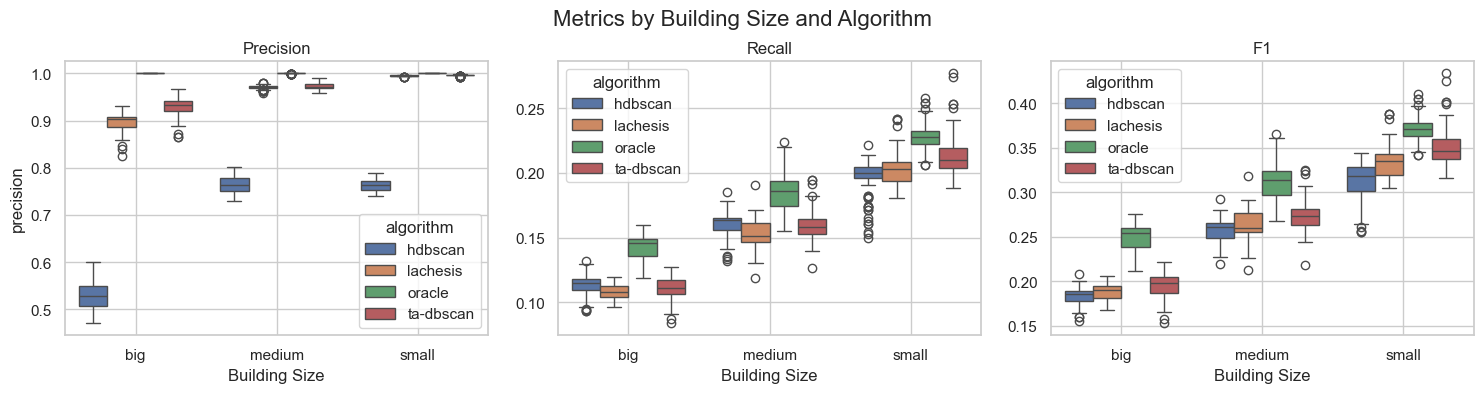

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt

prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, metric in zip(axes, prf_metrics):
    sns.boxplot(
        data=size_bootstrap_df,
        x="building_size",        # group on building size
        y=metric,
        hue="algorithm",          # different colors for each algorithm
        ax=ax
    )
    ax.set_title(metric.upper() if metric == "f1" else metric.title())
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.set_xlabel("Building Size")
    ax.grid(True)

fig.suptitle("Metrics by Building Size and Algorithm", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()


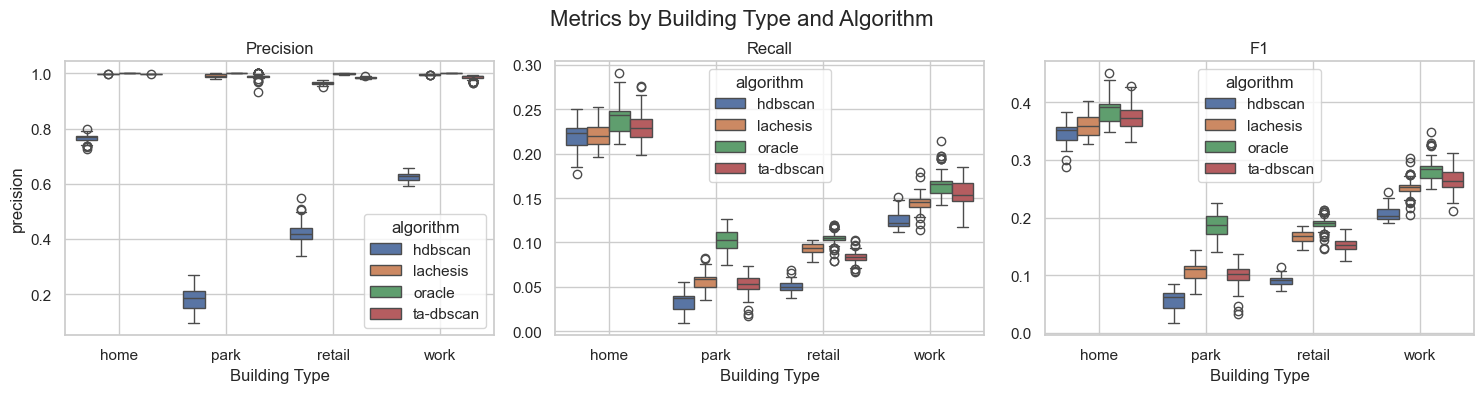

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt

prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, metric in zip(axes, prf_metrics):
    sns.boxplot(
        data=btype_bootstrap_df,
        x="building_type",        # group on building size
        y=metric,
        hue="algorithm",          # different colors for each algorithm
        ax=ax
    )
    ax.set_title(metric.upper() if metric == "f1" else metric.title())
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.set_xlabel("Building Type")
    ax.grid(True)

fig.suptitle("Metrics by Building Type and Algorithm", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()


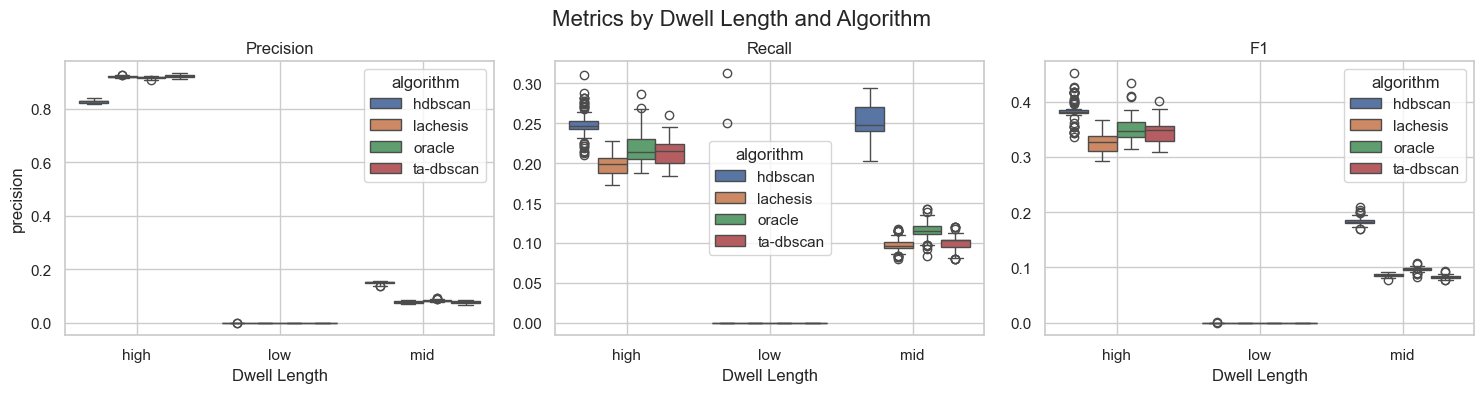

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt

prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, metric in zip(axes, prf_metrics):
    sns.boxplot(
        data=dwell_bootstrap_df,
        x="dwell_length",        # group on building size
        y=metric,
        hue="algorithm",          # different colors for each algorithm
        ax=ax
    )
    ax.set_title(metric.upper() if metric == "f1" else metric.title())
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.set_xlabel("Dwell Length")
    ax.grid(True)

fig.suptitle("Metrics by Dwell Length and Algorithm", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()


## Exploration of building size